## [In progress]: Dataset with Global Forest Change as a target

In [67]:
import pathlib
import pyproj
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import skimage.morphology as morph
import torch
import torch.nn.functional as F
import geopandas as gpd

from shapely.geometry import box    
from pyproj import Geod
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info
from utils import  get_credentials, download_composite

### Generate ROI with 512x512 pixels

In [2]:
with rasterio.open("./gfc/GFC_Cordoba.tif") as src:
    data = src.read(1)
    ## Plot the data
    data_2017 = data == 17
    data_2018 = data == 18
    data_2019 = data == 19
    data_2020 = data == 20
    data_2021 = data == 21
    data_2022 = data == 22
    data_2023 = data == 23

    # fig, ax = plt.subplots(2, 4, figsize=(20, 10))
    # ax[0, 0].imshow(data_2017)
    # ax[0, 0].set_title("2017")

    # ax[0, 1].imshow(data_2018)
    # ax[0, 1].set_title("2018")

    # ax[0, 2].imshow(data_2019)
    # ax[0, 2].set_title("2019")

    # ax[0, 3].imshow(data_2020)
    # ax[0, 3].set_title("2020")

    # ax[1, 0].imshow(data_2021)
    # ax[1, 0].set_title("2021")

    # ax[1, 1].imshow(data_2022)
    # ax[1, 1].set_title("2022")

    # ax[1, 2].imshow(data_2023)
    # ax[1, 2].set_title("2023")

    # for a in ax.ravel():
    #     a.axis("off")

    # plt.show()

In [ ]:
## Cómo puedo generar los puntos lat,long para esa gran área?
data.shape # (rows, cols) = (22310, 16137)

## Cambiar su transform
geotransform = src.transform

## Generate the bounding box of the image
lonmin, latmin, lonmax, latmax = src.bounds

tm_crs = query_utm_crs_info(datum_name="WGS84", area_of_interest=AreaOfInterest(lonmin, latmin, lonmax, latmax))
epsg_code = tm_crs[0].code

# Get upper left and lower right coordinates
ulat, ulon = geotransform.f, geotransform.c

tm_transform = pyproj.Transformer.from_crs("epsg:4326", f"epsg:{epsg_code}", always_xy=True)    
ulx, uly = tm_transform.transform(ulon, ulat)

## Recalculate the shape of the image given a new resolution
resolution = 30
nrows, ncols = data.shape

geod = Geod(ellps="WGS84")
*_, distance_x = geod.inv(lonmin, latmin, lonmax, latmin)
*_, distance_y = geod.inv(lonmin, latmin, lonmin, latmax)

xres_m = distance_x / ncols
yres_m = distance_y / nrows

new_nrows = int(nrows * yres_m / resolution)
new_ncols = int(ncols * xres_m / resolution)

## Interpolate the data
data_tensor = torch.from_numpy(data).unsqueeze(0)
data_int = F.interpolate(data_tensor, size=(new_ncols, new_nrows), mode="nearest").squeeze().numpy()

## Save the raster with the new transform
with rasterio.open("./gfc/GFC_Cordoba.tif") as src:
    data = src.read(1)
    profile = src.profile
    transform = rasterio.Affine(resolution, 0, ulx, 0, -resolution, uly)
    crs = f"EPSG:{epsg_code}"
    profile.update({"transform": transform, 
                    "crs": crs, 
                    "width": new_ncols, 
                    "height": new_nrows})
    
    with rasterio.open("./gfc/GFC_Cordoba_UTM.tif", "w", **profile) as dst:
        dst.write(data_int, 1)

In [58]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from pyproj import Transformer
import torch

# Abrir el raster original
with rasterio.open("./gfc/GFC_Cordoba.tif") as src:
    # Leer los datos y el perfil del raster
    data = src.read(1)
    profile = src.profile

    # Definir el CRS de destino
    dst_crs = 'EPSG:32720'

    # Calcular la transformación y el tamaño del nuevo raster
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    
    # Actualizar el perfil del raster
    profile.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    # Crear un tensor de PyTorch a partir de los datos del raster
    data_tensor = torch.tensor(data, dtype=torch.float32)

    # Reproyectar el raster
    reprojected_data = torch.zeros((height, width), dtype=torch.float32)
    reproject(
        source=data_tensor.numpy(),
        destination=reprojected_data.numpy(),
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=transform,
        dst_crs=dst_crs,
        resampling=Resampling.nearest
    )

    # Guardar el raster reproyectado
    with rasterio.open("./gfc/GFC_Cordoba_UTM.tif", "w", **profile) as dst:
        dst.write(reprojected_data.numpy(), 1)

In [68]:
with rasterio.open("./gfc/GFC_Cordoba_UTM.tif") as src:
    datautm = src.read(1)
    nrows, ncols = datautm.shape
    geotransform = src.transform
    minx, miny, maxx, maxy = src.bounds
    epsg_code = src.crs.to_epsg()

In [70]:
# Generate a fishnet grid
## Get upper left and lower right coordinates
grid_cells = 5120

x_coords = np.arange(minx, maxx, grid_cells)
y_coords = np.arange(miny, maxy, grid_cells)

bboxs = []
for x in x_coords:
    for y in y_coords:
        bboxs.append(box(x, y, x + grid_cells, y + grid_cells))

## Save the fishnet grid
print(f"Number of cells: {len(bboxs)}")

## Save the fishnet grid as GeoJSON
## Filter again by building count
grid = gpd.GeoDataFrame({'id': list(range(len(bboxs))),
                          'geometry': bboxs}, 
                           crs=f"EPSG:{epsg_code}")

grid.to_file("./gfc/fishnet_grid.geojson", driver="GeoJSON")

Number of cells: 9394


In [71]:
## Obtener los vectores que intersectan con el raster
for index, row in grid.iterrows():
    geom = row["geometry"]
    with rasterio.open("./gfc/GFC_Cordoba_UTM.tif") as src:
        out_image = src.read(1, window=src.window(*geom.bounds))
        if np.count_nonzero(out_image) > 0:
            grid.loc[index, "intersect"] = True
            grid.loc[index, "deforestation_count"] = np.count_nonzero(out_image)
        else:
            grid.loc[index, "intersect"] = False

    print(f"[INFO] {index} / {len(grid)}")  

[INFO] 0 / 9394
[INFO] 1 / 9394
[INFO] 2 / 9394
[INFO] 3 / 9394
[INFO] 4 / 9394
[INFO] 5 / 9394
[INFO] 6 / 9394
[INFO] 7 / 9394
[INFO] 8 / 9394
[INFO] 9 / 9394
[INFO] 10 / 9394
[INFO] 11 / 9394
[INFO] 12 / 9394
[INFO] 13 / 9394
[INFO] 14 / 9394
[INFO] 15 / 9394
[INFO] 16 / 9394
[INFO] 17 / 9394
[INFO] 18 / 9394
[INFO] 19 / 9394
[INFO] 20 / 9394
[INFO] 21 / 9394
[INFO] 22 / 9394
[INFO] 23 / 9394
[INFO] 24 / 9394
[INFO] 25 / 9394
[INFO] 26 / 9394
[INFO] 27 / 9394
[INFO] 28 / 9394
[INFO] 29 / 9394
[INFO] 30 / 9394
[INFO] 31 / 9394
[INFO] 32 / 9394
[INFO] 33 / 9394
[INFO] 34 / 9394
[INFO] 35 / 9394
[INFO] 36 / 9394
[INFO] 37 / 9394
[INFO] 38 / 9394
[INFO] 39 / 9394
[INFO] 40 / 9394
[INFO] 41 / 9394
[INFO] 42 / 9394
[INFO] 43 / 9394
[INFO] 44 / 9394
[INFO] 45 / 9394
[INFO] 46 / 9394
[INFO] 47 / 9394
[INFO] 48 / 9394
[INFO] 49 / 9394
[INFO] 50 / 9394
[INFO] 51 / 9394
[INFO] 52 / 9394
[INFO] 53 / 9394
[INFO] 54 / 9394
[INFO] 55 / 9394
[INFO] 56 / 9394
[INFO] 57 / 9394
[INFO] 58 / 9394
[INFO] 

In [ ]:
grid_order = grid[grid["intersect"] == True].sort_values("deforestation_count", ascending=False)
grid_order

,id,geometry,intersect,deforestation_count
2790,2790,"POLYGON ((349284.275 6665960.083, 349284.275 6...",True,26909.0
3161,3161,"POLYGON ((364644.275 6691560.083, 364644.275 6...",True,25538.0
2789,2789,"POLYGON ((349284.275 6660840.083, 349284.275 6...",True,25126.0
2414,2414,"POLYGON ((333924.275 6614760.083, 333924.275 6...",True,24623.0
2668,2668,"POLYGON ((344164.275 6665960.083, 344164.275 6...",True,22540.0
...,...,...,...,...
1777,1777,"POLYGON ((308324.275 6476520.083, 308324.275 6...",True,1.0
1744,1744,"POLYGON ((308324.275 6307560.083, 308324.275 6...",True,1.0
3255,3255,"POLYGON ((369764.275 6548200.083, 369764.275 6...",True,1.0
1200,1200,"POLYGON ((282724.275 6645480.083, 282724.275 6...",True,1.0


In [78]:
filter_grid = grid_order[grid_order['deforestation_count'] > 10*11]
filter_grid.to_file("./gfc/filter_grid.geojson", driver="GeoJSON")

In [79]:
with rasterio.open("./gfc/GFC_Cordoba_UTM.tif") as src:
    data = src.read(1)
    profile = src.profile

    for index, row in filter_grid.iterrows():
        geom = row["geometry"]
        out_image = src.read(1, window=src.window(*geom.bounds))
        for i in range(1, 24):
            if np.count_nonzero(out_image == i) > 0:
                filter_grid.loc[index, f"deforestation_{i}"] = np.count_nonzero(out_image == i)
    
    print(f"[INFO] {index} / {len(filter_grid)}")

/home/tidop/Documentos/miniconda3/envs/omdena/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/tidop/Documentos/miniconda3/envs/omdena/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/tidop/Documentos/miniconda3/envs/omdena/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is

[INFO] 5549 / 2830


In [83]:
filter_2017 = filter_grid[filter_grid["deforestation_17"] > 0]
filter_2018 = filter_grid[filter_grid["deforestation_18"] > 0]
filter_2019 = filter_grid[filter_grid["deforestation_19"] > 0]
filter_2020 = filter_grid[filter_grid["deforestation_20"] > 0]
filter_2021 = filter_grid[filter_grid["deforestation_21"] > 0]
filter_2022 = filter_grid[filter_grid["deforestation_22"] > 0]
filter_2023 = filter_grid[filter_grid["deforestation_23"] > 0]

In [98]:
## First 20 cells
filter_2023.sort_values("deforestation_23", ascending=False).head(20).to_file("./gfc/filter_2023.geojson", driver="GeoJSON")

In [102]:
import os
import ee
from dotenv import load_dotenv

# Get the notebook directory
NOTEBOOK_DIR = os.getcwd()

# Get the project root directory (two levels up)
PROJECT_ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, '../..'))

# Load environment variables
load_dotenv()

# Get credentials path and ensure it's relative to PROJECT_ROOT
GEE_CREDENTIALS_PATH = os.path.join(PROJECT_ROOT, os.getenv('GEE_CREDENTIALS_PATH'))
GEE_PROJECT_ID = os.getenv('GEE_PROJECT_ID')

# Initialize GEE
credentials = ee.ServiceAccountCredentials(
    '',
    GEE_CREDENTIALS_PATH,
    GEE_PROJECT_ID
)
ee.Initialize(credentials, opt_url="https://earthengine-highvolume.googleapis.com")

In [106]:
get_credentials()
## Comenzamos a descargar las imágenes
GFC_GEOJSON_FOLDER = pathlib.Path("./gfc/geojson")
geojson_files = sorted(list(GFC_GEOJSON_FOLDER.glob("*.geojson")))

OUT_FOLDER = pathlib.Path("/media/tidop/Datos_4TB1/databases")

GFC_FOLDER = OUT_FOLDER / "gfc"
GFC_FOLDER.mkdir(exist_ok=True, parents=True)

T1_FOLDER = GFC_FOLDER / "t1"
T1_FOLDER.mkdir(exist_ok=True, parents=True)

T2_FOLDER = GFC_FOLDER / "t2"
T2_FOLDER.mkdir(exist_ok=True, parents=True)

GT_FOLDER = GFC_FOLDER / "gt"
GT_FOLDER.mkdir(exist_ok=True, parents=True)

counter = 0

for i, geojson_file in enumerate(geojson_files):
    print(f"[INFO] Downloading {geojson_file}")
    gdf = gpd.read_file(geojson_file)
    year = int(geojson_file.stem.split("_")[1])
    for index, row in gdf.iterrows():
        geom = row["geometry"]
        x, y = geom.centroid.x, geom.centroid.y
        nstr = str(counter).zfill(4)
        ## Convertir a geográficas
        crs = gdf.crs.to_epsg()
        utm2geo = pyproj.Transformer.from_crs(f"EPSG:{crs}", "EPSG:4326", always_xy=True)
        lon, lat = utm2geo.transform(x, y)

        try: 
            ## Descargar la imagen T1
            download_composite(lat, lon, T1_FOLDER / f"{nstr}.tif", 512, 10, f"{year - 1}-01-01", f"{year - 1}-12-31", 0.6)
            print(f"[INFO] Downloading T1 {nstr}")
            
            ## Descargar la imagen T2
            download_composite(lat, lon, T2_FOLDER / f"{nstr}.tif", 512, 10, f"{year}-01-01", f"{year}-12-31", 0.6)
            print(f"[INFO] Downloading T2 {nstr}")

            ## Descargar la imagen GT
            with rasterio.open("./gfc/GFC_Cordoba_UTM.tif") as src:
                data = src.read(1)
                minx, miny, maxx, maxy = geom.bounds

                out_data = src.read(1, window=src.window(minx, miny, maxx, maxy))
                year_n = year - 2000
                year_data = (out_data == year_n).astype(np.uint8)

                ## New transform
                transform = rasterio.Affine(10, 0, minx, 0, -10, maxy)

                ## Interpolate the data
                data_tensor = torch.from_numpy(year_data).unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
                data_int = F.interpolate(data_tensor, size=(512, 512), mode="nearest").squeeze().numpy()

                ## Save the raster with the new transform
                with rasterio.open(GT_FOLDER / f"{nstr}.tif", "w", driver="GTiff", 
                                height=512, width=512, count=1, dtype=np.uint8, 
                                crs=f"EPSG:{crs}", transform=transform) as dst:
                    dst.write(data_int, 1)
            
            print(f"[INFO] Downloading GT {nstr}")

            counter += 1        
        except Exception as e:
            print(f"[ERROR] {e}")
            continue
    
    print(f"[INFO] [DONE] {i+1} / {len(geojson_files)}")

[INFO] Downloading gfc/geojson/filter_2017.geojson
Sentinel-2 available images: 0
[ERROR] Image has no band named "B2".
Sentinel-2 available images: 0
[ERROR] Image has no band named "B2".
Sentinel-2 available images: 0
[ERROR] Image has no band named "B2".
Sentinel-2 available images: 0
[ERROR] Image has no band named "B2".
Sentinel-2 available images: 0
[ERROR] Image has no band named "B2".
Sentinel-2 available images: 0
[ERROR] Image has no band named "B2".
Sentinel-2 available images: 0
[ERROR] Image has no band named "B2".
Sentinel-2 available images: 0
[ERROR] Image has no band named "B2".
Sentinel-2 available images: 0
[ERROR] Image has no band named "B2".
Sentinel-2 available images: 0
[ERROR] Image has no band named "B2".
Sentinel-2 available images: 0
[ERROR] Image has no band named "B2".
Sentinel-2 available images: 0
[ERROR] Image has no band named "B2".
Sentinel-2 available images: 0
[ERROR] Image has no band named "B2".
Sentinel-2 available images: 0
[ERROR] Image has no 

/home/tidop/Documentos/miniconda3/envs/omdena/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: Several features with id = 2736 have been found. Altering it to be unique. This warning will not be emitted anymore for this layer
  return ogr_read(


Sentinel-2 available images: 112
Image saved in /media/tidop/Datos_4TB1/databases/gfc/t1/0030.tif
[INFO] Downloading T1 0030
Sentinel-2 available images: 107
Image saved in /media/tidop/Datos_4TB1/databases/gfc/t2/0030.tif
[INFO] Downloading T2 0030
[INFO] Downloading GT 0030
Sentinel-2 available images: 230
Image saved in /media/tidop/Datos_4TB1/databases/gfc/t1/0031.tif
[INFO] Downloading T1 0031
Sentinel-2 available images: 217
Image saved in /media/tidop/Datos_4TB1/databases/gfc/t2/0031.tif
[INFO] Downloading T2 0031
[INFO] Downloading GT 0031
Sentinel-2 available images: 113
Image saved in /media/tidop/Datos_4TB1/databases/gfc/t1/0032.tif
[INFO] Downloading T1 0032
Sentinel-2 available images: 107
Image saved in /media/tidop/Datos_4TB1/databases/gfc/t2/0032.tif
[INFO] Downloading T2 0032
[INFO] Downloading GT 0032
Sentinel-2 available images: 51
Image saved in /media/tidop/Datos_4TB1/databases/gfc/t1/0033.tif
[INFO] Downloading T1 0033
Sentinel-2 available images: 57
Image saved i

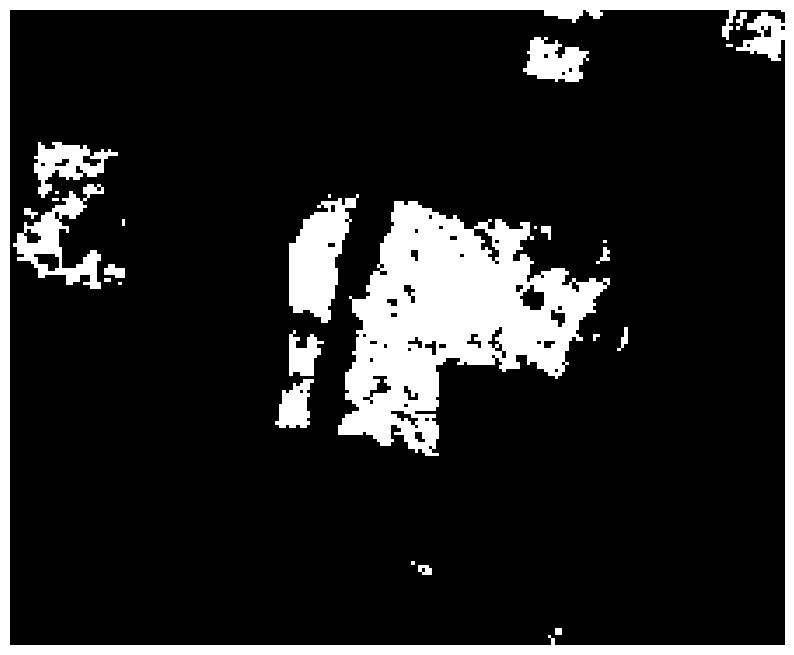

In [9]:
## Generar puntos de evaluación para cada uno de ellos
lat, lon = -32.56392,-64.72977
year = 21

## Obtener el EPSG code
tm_crs = query_utm_crs_info(datum_name="WGS84", area_of_interest=AreaOfInterest(lon, lat, lon, lat))
epsg_code = tm_crs[0].code

## Convertir a TM
geo2met = pyproj.Transformer.from_crs('epsg:4326', f'epsg:{epsg_code}', always_xy=True)
x, y = geo2met.transform(lon, lat)

## Definir el bbox
bbox = [x - 2560, y - 2560, x + 2560, y + 2560]

## Turn back to geographic coordinates
met2geo = pyproj.Transformer.from_crs(f'epsg:{epsg_code}', 'epsg:4326', always_xy=True)
lx, ly = met2geo.transform(bbox[0], bbox[1])
rx, ry = met2geo.transform(bbox[2], bbox[3])

bbox_geo = [lx, ly, rx, ry]


with rasterio.open("./gfc/GFC_Cordoba.tif") as src:
    # Calculate the window to read
    window = rasterio.windows.from_bounds(*bbox_geo, transform=src.transform)
    out_image = src.read(1, window=window)
    out_image_2021 = (out_image == year)

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(out_image_2021, cmap="gray")
    ax.axis("off")
    plt.show()

In [ ]:
# Get credentials
# credentials = get_credentials() 

DB_FOLDER = pathlib.Path("/media/tidop/Datos_4TB1/databases")
GFC_FOLDER = DB_FOLDER / "gfc"
GFC_FOLDER.mkdir(parents=True, exist_ok=True)

# As example, we will download the GFC data for 2020 and 2021
lat, lon = -32.56392,-64.72977

download_composite(lat, lon, f"{GFC_FOLDER}/2020.tif", 512, 10, "2020-01-01", "2020-12-31", 0.6)
download_composite(lat, lon, f"{GFC_FOLDER}/2021.tif", 512, 10, "2021-01-01", "2021-12-31", 0.6)

## Bounding box from the lat,lon
## Convert to metric coordinates
tm_crs = query_utm_crs_info(datum_name="WGS84", area_of_interest=AreaOfInterest(lon, lat, lon, lat))
epsg_code = tm_crs[0].code

geo2met = pyproj.Transformer.from_crs('epsg:4326', f'epsg:{epsg_code}', always_xy=True)
x, y = geo2met.transform(lon, lat)

bbox = [x - 2560, y - 2560, x + 2560, y + 2560]

## Turn back to geographic coordinates
met2geo = pyproj.Transformer.from_crs(f'epsg:{epsg_code}', 'epsg:4326', always_xy=True)
lx, ly = met2geo.transform(bbox[0], bbox[1])
rx, ry = met2geo.transform(bbox[2], bbox[3])

bbox_geo = [lx, ly, rx, ry]

raster_file = GFC_FOLDER / "Hansen_GFC-2023-v1.11_lossyear_30S_070W.tif"

## Plot the images
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
with rasterio.open(f"{GFC_FOLDER}/2020.tif") as src1, rasterio.open(f"{GFC_FOLDER}/2021.tif") as src2, \
    rasterio.open(raster_file) as src3:
    # Calculate the window to read
    window = rasterio.windows.from_bounds(*bbox_geo, transform=src3.transform)
    out_image = src3.read(1, window=window)
    
    ax[0,0].imshow(src1.read([3, 2, 1]).transpose(1, 2, 0) * 6/ 10000)
    ax[0,0].set_title("S2 Composite 2020")

    ax[0,1].imshow(src2.read([3, 2, 1]).transpose(1, 2, 0) * 6/ 10000)
    ax[0,1].set_title("S2 Composite 2021")

    out_image_2021 = (out_image == 21).astype(np.uint8)
    ax[0,2].imshow(out_image_2021, cmap='gray')
    ax[0,2].set_title("GFC Ground Truth 2021")

    out_cleaned_2021 = morph.remove_small_objects(out_image_2021, min_size=64, connectivity=1)

    ax[1,0].imshow(out_cleaned_2021, cmap='gray')
    ax[1,0].set_title("GFC Ground Truth 2021 Cleaned") 

    # Resize to shape of 512,512 for GFC 2021 using torch.nn.functional.interpolate
    out_interp_2021 = F.interpolate(torch.tensor(out_cleaned_2021).unsqueeze(0).unsqueeze(0).float(), 
                                     size=(512, 512)).squeeze().numpy()
    # Add 10m resolution when it's exported
    ax[1,1].imshow(out_interp_2021, cmap='gray')
    ax[1,1].set_title("GFC GT 2021 Cleaned Resized")    
    
    # GT Contour
    ax[1,2].contour(out_interp_2021, colors='red', levels=[0.5])
    ax[1,2].imshow(src2.read([3, 2, 1]).transpose(1, 2, 0) * 6 /10000)
    ax[1,2].set_title(f"GT Contour")
        
    plt.show()